# EDA

### Importando Bibliotecas

In [183]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import shapiro

### Carregando Dados

In [184]:
NDVI_PATH = "../data/PROCESSED/ndvi.csv"
SIDRA_PATH = "../data/PROCESSED/manhuacu.csv"

NDVI_df = pd.read_csv(NDVI_PATH)
NDVI_df = NDVI_df.rename(columns={"date": "Data", "ndvi": "NDVI"})
NDVI_df["Year"] = pd.to_datetime(NDVI_df["Data"]).dt.year
NDVI_df.to_csv(
    "../data/PROCESSED/ndvi.csv",
    index=False,
)

SIDRA_df = pd.read_csv(SIDRA_PATH)
SIDRA_df = SIDRA_df[(SIDRA_df["Year"] >= 2000) & (SIDRA_df["Year"] <= 2023)]


In [185]:
yearly_mean_ndvi = NDVI_df.groupby('Year')['NDVI'].mean().reset_index()
yearly_mean_ndvi.columns = ['Year', 'Mean NDVI']

In [186]:
complete_df = SIDRA_df.merge(yearly_mean_ndvi, on='Year', how='inner')

### Produção, Área, NDVI e Produtividade e NDVI ao Longo do Tempo


#### Resumo

In [187]:
# Get first and last rows
first = complete_df.iloc[0]
last = complete_df.iloc[-1]

# Calculate difference and percentage
diff = last - first
perc = (diff / first) * 100

# Build and format summary DataFrame
summary = pd.DataFrame({
    'First': first,
    'Last': last,
    'Diff': diff,
    'Perc': perc
})

# Formatting
def format_column(col):
    def format_value(v, row):
        if row == 'Year':
            return str(int(v))
        elif col.name == 'Perc':
            return f"{v:.2f}%"
        else:
            return f"{v:,.2f}"
    return [format_value(v, row) for row, v in col.items()]

formatted_summary = summary.apply(format_column)

print(formatted_summary)


                              First           Last          Diff    Perc
Year                           2000           2023            23       1
Production (kg)       17,424,000.00  25,680,000.00  8,256,000.00  47.38%
Area (ha)                 13,200.00      21,400.00      8,200.00  62.12%
Productivity (kg/ha)       1,320.00       1,200.00       -120.00  -9.09%
Mean NDVI                      0.41           0.37         -0.04  -8.74%


- **Produção (kg)**: Aumentou de 17,4 milhões (2000) para 25,7 milhões (2023), representando um crescimento de 47,38%.
- **Área (ha)**: Expansão de 13.200 ha para 21.400 ha no período, um aumento de 62,12%, indicando uma estratégia de crescimento extensivo.
- **Produtividade (kg/ha)**: Caiu de 1.320 para 1.200 kg/ha, uma redução de 9,09%, sugerindo menor eficiência por área.
- **NDVI Médio**: Diminuiu de 0,41 para 0,37 (-8,74%), o que pode indicar leve declínio na qualidade vegetativa, possivelmente associado à queda de produtividade.

#### Plots da Produção, Área, NDVI e Produtividade ao Longo do Tempo

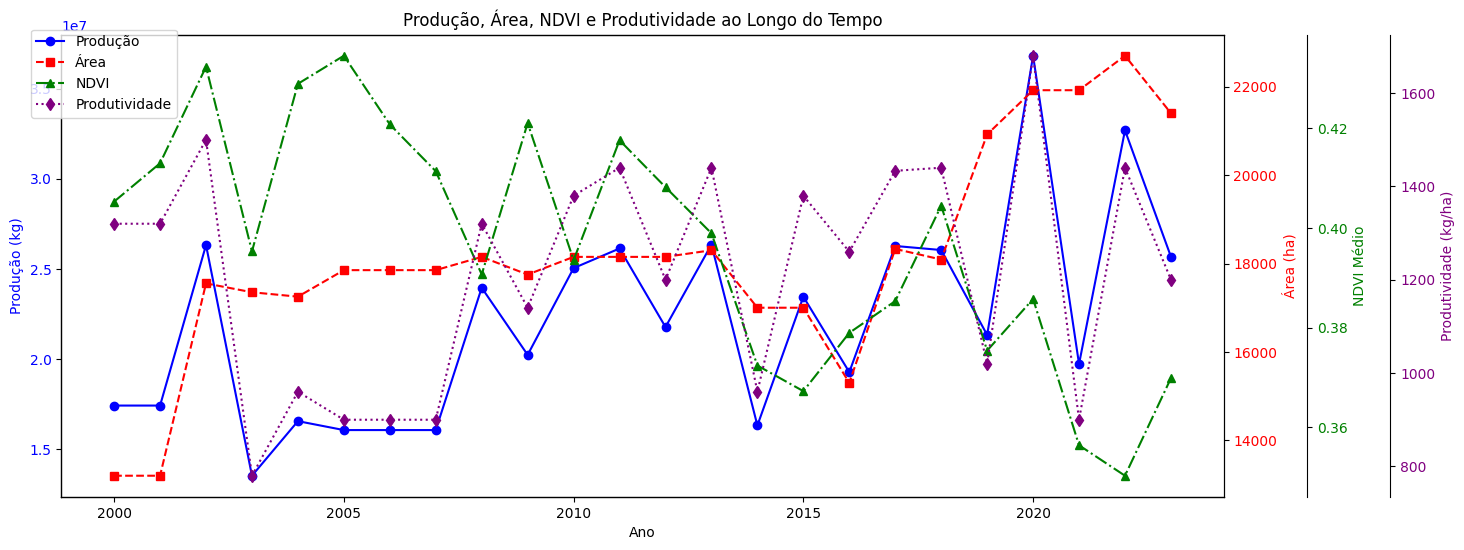

In [188]:
fig, ax1 = plt.subplots(figsize=(15, 6))

# Production
ax1.plot(complete_df['Year'], complete_df['Production (kg)'], color='blue', marker='o', label='Produção')
ax1.set_xlabel('Ano')
ax1.set_ylabel('Produção (kg)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Area
ax2 = ax1.twinx()
ax2.plot(complete_df['Year'], complete_df['Area (ha)'], color='red', marker='s', linestyle='--', label='Área')
ax2.set_ylabel('Área (ha)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# NDVI
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(complete_df['Year'], complete_df['Mean NDVI'], color='green', marker='^', linestyle='-.', label='NDVI')
ax3.set_ylabel('NDVI Médio', color='green')
ax3.tick_params(axis='y', labelcolor='green')

# Productivity
ax4 = ax1.twinx()
ax4.spines['right'].set_position(('outward', 120))
ax4.plot(complete_df['Year'], complete_df['Productivity (kg/ha)'], color='purple', marker='d', linestyle=':', label='Produtividade')
ax4.set_ylabel('Produtividade (kg/ha)', color='purple')
ax4.tick_params(axis='y', labelcolor='purple')


fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.title('Produção, Área, NDVI e Produtividade ao Longo do Tempo')
plt.show()

### Relação entre Variáveis

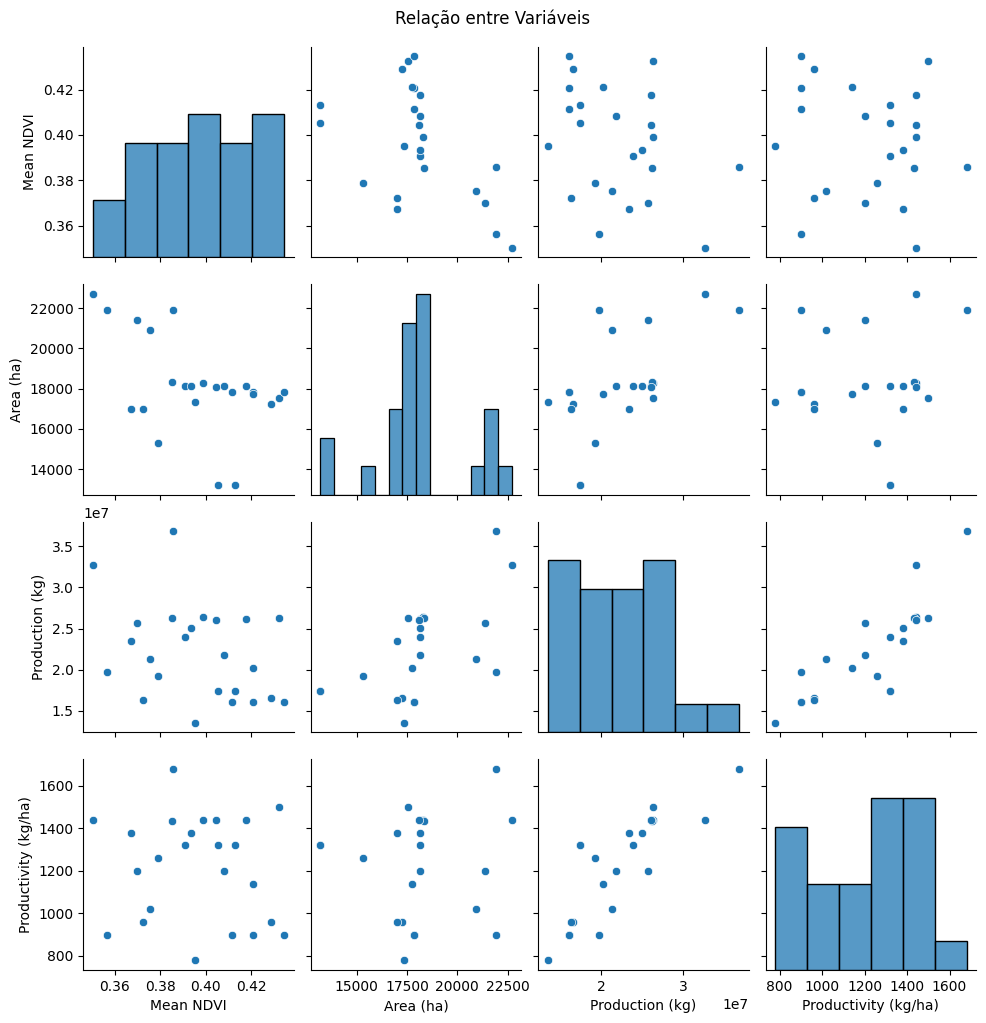

In [189]:
sns.pairplot(complete_df[['Mean NDVI', 'Area (ha)', 'Production (kg)', 'Productivity (kg/ha)']])
plt.suptitle('Relação entre Variáveis', y=1.02)
plt.show()

### Detecção de Dados Faltantes

In [197]:
missing_table = complete_df[['Year', 'Mean NDVI', 'Area (ha)', 'Production (kg)', 'Productivity (kg/ha)']].isnull().sum().reset_index()
missing_table.columns = ['Variável', 'Dados Faltantes']
missing_table

,Variável,Dados Faltantes
0,Year,0
1,Mean NDVI,0
2,Area (ha),0
3,Production (kg),0
4,Productivity (kg/ha),0


### Distribuição das Variáveis (Identificação de Outliers)


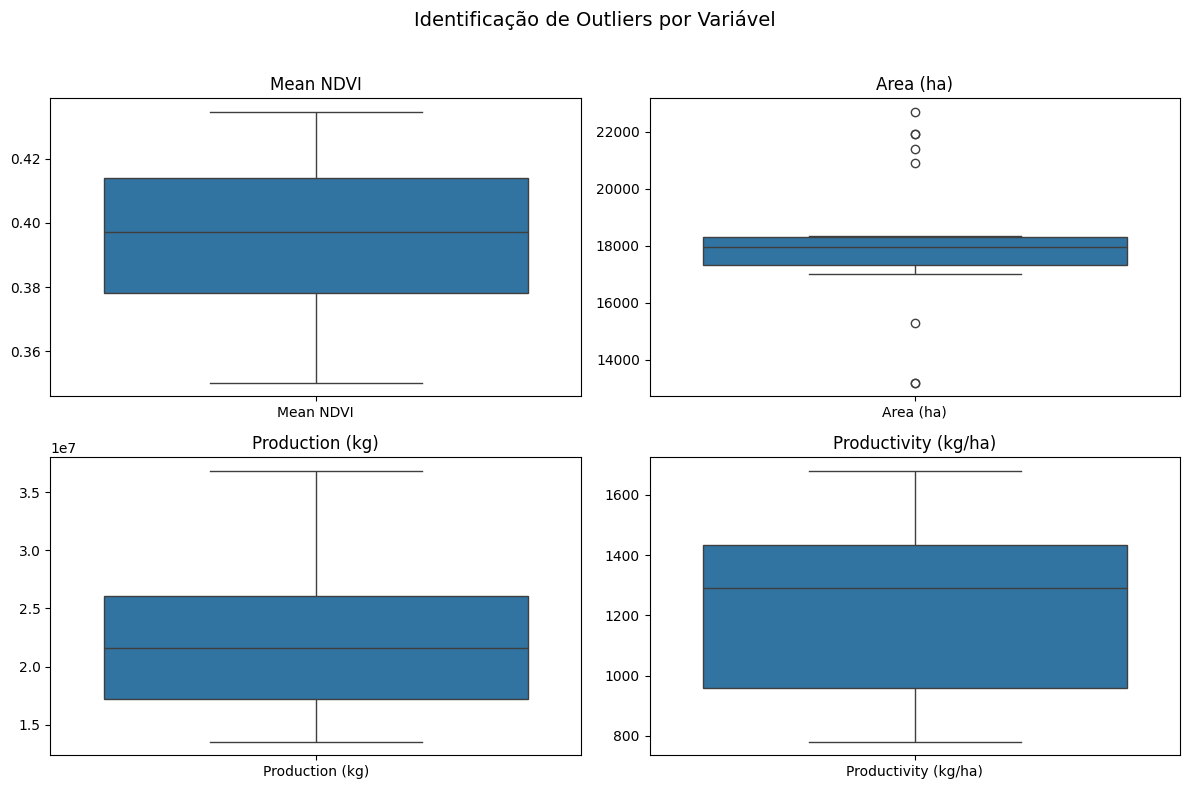

In [198]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

sns.boxplot(data=complete_df[['Mean NDVI']], ax=axes[0, 0])
axes[0, 0].set_title('Mean NDVI')
axes[0, 0].set_xlabel('')

sns.boxplot(data=complete_df[['Area (ha)']], ax=axes[0, 1])
axes[0, 1].set_title('Area (ha)')
axes[0, 1].set_xlabel('')

sns.boxplot(data=complete_df[['Production (kg)']], ax=axes[1, 0])
axes[1, 0].set_title('Production (kg)')
axes[1, 0].set_xlabel('')

sns.boxplot(data=complete_df[['Productivity (kg/ha)']], ax=axes[1, 1])
axes[1, 1].set_title('Productivity (kg/ha)')
axes[1, 1].set_xlabel('')

plt.suptitle('Identificação de Outliers por Variável', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


- Área (ha): Distribuição assimétrica, com outliers acima de 20,000 ha (expansão extrema).
- Produção (kg): Concentrada entre 1.5M kg e 3.0M kg, com poucos valores extremos.
- NDVI: Valores estreitos (0.36–0.42), indicando pouca variação na fertilidade.

Insights:
  - Outliers em Área sugerem anos com expansão territorial atípica (ex.: políticas agrícolas).
  - Baixa variabilidade do NDVI limita sua utilidade como preditor.

### P-values das Variáveis

In [192]:
cols = ['Mean NDVI', 'Area (ha)', 'Production (kg)', 'Productivity (kg/ha)']
shapiro_results = [(col, shapiro(complete_df[col])[1]) for col in cols]

# Convert to DataFrame
shapiro_df = pd.DataFrame(shapiro_results, columns=['Variable', 'p-value'])
shapiro_df['p-value'] = shapiro_df['p-value'].map(lambda p: f"{p:.4f}")
shapiro_df

,Variable,p-value
0,Mean NDVI,0.7470
1,Area (ha),0.0120
2,Production (kg),0.0880
3,Productivity (kg/ha),0.0841


### Correlações entre NDVI, Área e Produção

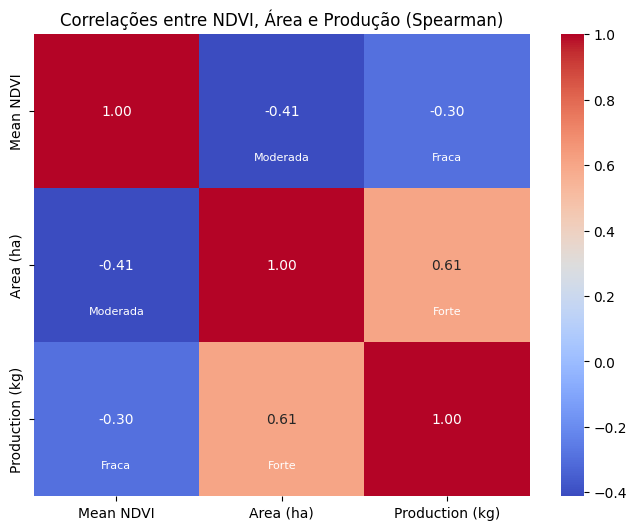

In [193]:
def interpretar_correlacao(r):
    r = abs(r)
    if r < 0.2:
        return "Muito fraca"
    elif r < 0.4:
        return "Fraca"
    elif r < 0.6:
        return "Moderada"
    elif r < 0.8:
        return "Forte"
    else:
        return "Muito forte"

correlacoes = complete_df[['Mean NDVI', 'Area (ha)', 'Production (kg)']].corr(method='spearman')

plt.figure(figsize=(8, 6))
ax = sns.heatmap(correlacoes, annot=True, cmap='coolwarm', fmt=".2f")

# Add interpretation text
for i in range(len(correlacoes)):
    for j in range(len(correlacoes)):
        if i != j:
            r = correlacoes.iloc[i, j]
            strength = interpretar_correlacao(r)
            ax.text(j+0.5, i+0.8, strength, ha='center', va='center', fontsize=8, color='white')

plt.title('Correlações entre NDVI, Área e Produção (Spearman)')
plt.show()

- NDVI × Produção: Correlação negativa (-0.30), contradizendo expectativas.
- Área × Produção: Correlação positiva forte (0.84), confirmando dependência da expansão.
- NDVI × Área: Correlação negativa (-0.41), indicando que áreas maiores têm NDVI mais baixo.

#### Insights:

- A correlação negativa NDVI-Produção pode indicar expansão para terras menos férteis.
- A forte relação Área-Produção reforça a estratégia extensiva.

#### Justificativa do Uso do Método Spearman

- `Area` possui outliers (observe o gráfico de Identificação de Outliers).
- Dados não são distribuídos normalmente (p-value de `Area` é menor que 0.5).
- A relação entre as variáveis não se parece linear (observe Relação entre Variáveis).

### Relação entre NDVI, Área e Produção
  - Áreas grandes (20,000+ ha): Associadas a NDVI baixo (~0.36) e produção alta (~3.0M kg).
  - Áreas médias (16,000–18,000 ha): NDVI mais alto (~0.40), mas produção menor (~2.0M kg).

Insights:
  - Produção elevada em áreas grandes com NDVI baixo sugere diminuição da eficiência por hectare.
  - Áreas menores com NDVI alto não são priorizadas, indicando foco em quantidade sobre qualidade.

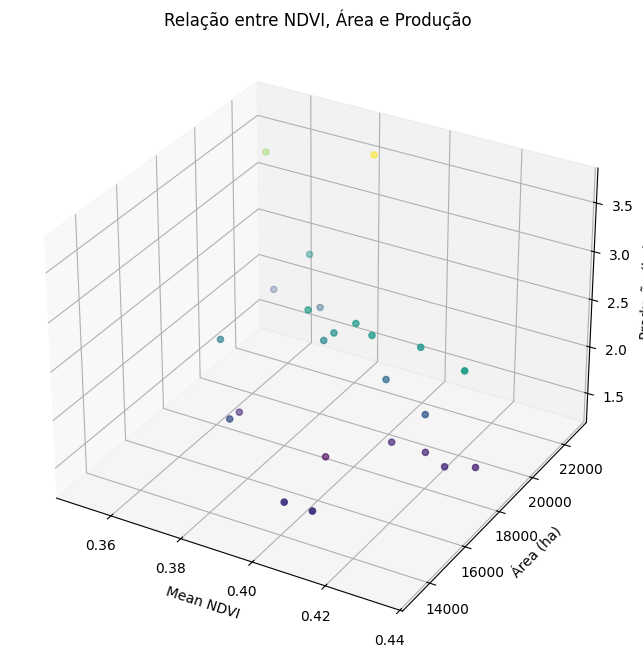

In [194]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    complete_df['Mean NDVI'],
    complete_df['Area (ha)'],
    complete_df['Production (kg)'],
    c=complete_df['Production (kg)'],
    cmap='viridis'
)
ax.set_xlabel('Mean NDVI')
ax.set_ylabel('Área (ha)')
ax.set_zlabel('Produção (kg)')
plt.title('Relação entre NDVI, Área e Produção')
plt.show()

### Densidade de Produção: NDVI vs Área
  - Maior densidade de produção: Concentrada em NDVI 0.38–0.40 e Área 16,000–18,000 ha.
  - Baixa densidade: NDVI < 0.36 (áreas degradadas) ou Área > 20,000 ha (superexpansão).

Insights:
  - Combinação ideal: NDVI médio (~0.39) e Área moderada (~17,000 ha).
  - Expansão além de 20,000 ha pode levar a degradação ambiental sem ganhos proporcionais.

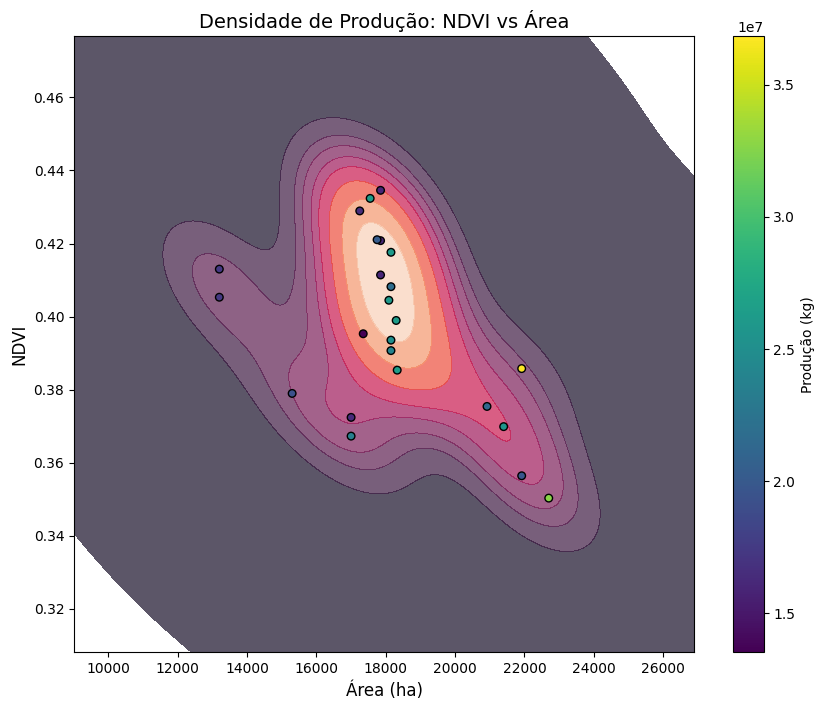

In [195]:
plt.figure(figsize=(10, 8))
contour = sns.kdeplot(
    x=complete_df['Area (ha)'], 
    y=complete_df['Mean NDVI'], 
    fill=True, 
    thresh=0,
    levels=10,
    cmap='rocket',
    alpha=0.7
)
plt.scatter(
    x=complete_df['Area (ha)'], 
    y=complete_df['Mean NDVI'], 
    c=complete_df['Production (kg)'],
    s=30,
    cmap='viridis',
    edgecolor='black'
)
plt.colorbar(label='Produção (kg)')
plt.title('Densidade de Produção: NDVI vs Área', fontsize=14)
plt.xlabel('Área (ha)', fontsize=12)
plt.ylabel('NDVI', fontsize=12)
plt.show()

### Regressão Linear entre as Variáveis


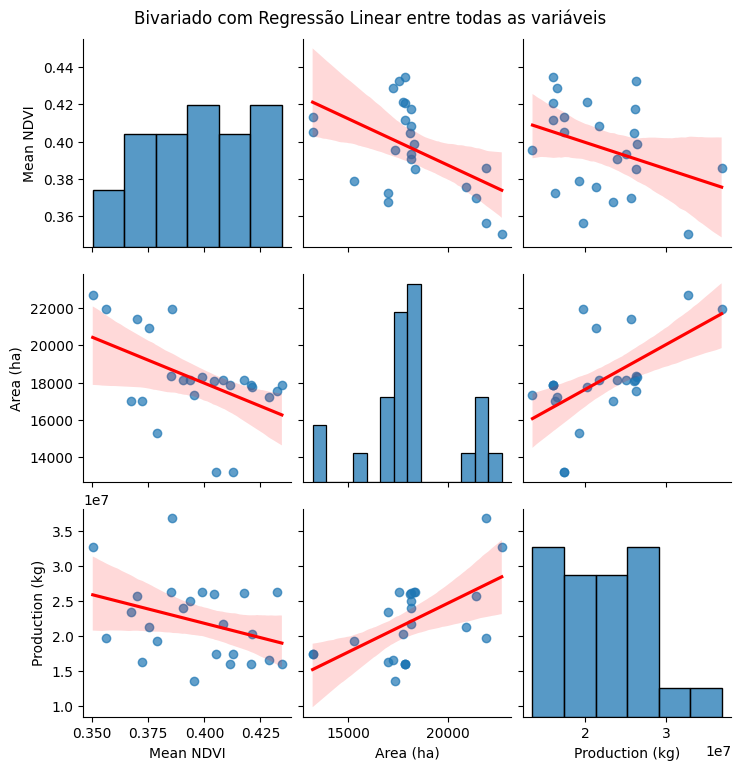

In [196]:


sns.pairplot(
    complete_df[['Mean NDVI', 'Area (ha)', 'Production (kg)']],
    kind='reg',  # This adds the regression line to each scatter plot
    plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha':0.7}}
)
plt.suptitle('Bivariado com Regressão Linear entre todas as variáveis', y=1.02)
plt.show()